In [1]:
from math import pi
import matplotlib.pyplot as plt
from pennylane import numpy as np
import pennylane as qml
from pennylane.optimize import AdamOptimizer
import datetime
now=datetime.datetime.now

In [2]:
num_qubits=2
dev=qml.device('default.qubit', wires=num_qubits)

In [3]:
# Boundary condition 
# X_0 = 0
# Y_1 = 1
X_0_v = 2.6885377567769764
Y_0_v = -3.790585633545575


In [4]:
# Differential equation's exact solution - for comparison
def X_t(t):
    return X_0_v*np.cos(t)+(3*X_0_v+2*Y_0_v)*np.sin(t)

def Y_t(t):
    return Y_0_v*np.cos(t)-(3*Y_0_v+5*X_0_v)*np.sin(t)

In [5]:
# Systems of Differential equation 
def F_E1(X_prime, X,Y_prime,Y, t):       # DE, works with numpy arrays
    return X_prime+Y_prime+2*X+Y

def F_E2(X_prime, X,Y_prime,Y, t):       # DE, works with numpy arrays
    return Y_prime+5*X+3*Y

In [6]:
t=np.random.uniform(0,4,size=100,requires_grad=False)

In [7]:
# define embedding layer
def embedding(x,wires):
    qml.RY(x, wires=wires[1])

In [8]:
def Ham():
    obs=[]
    for j in range(num_qubits):
        obs.append(qml.PauliX(j))
        for k in range(j):
            obs.append(qml.PauliZ(j)@qml.PauliZ(k))
    coeffs=np.random.uniform(-1,1,len(obs))*10
    qml.Hamiltonian(coeffs, obs)

In [9]:
# define ansastz layer
def layer(theta):
    
    # Apply Hamiltonian matrix
    Ham()
    
    # Apply H gate
    qml.Hadamard(0)
    
    # rotations on qubit 1
    qml.RY(theta,wires=1)
    
    # CNOT
    qml.CNOT(wires=[0, 1])

In [10]:
@qml.qnode(dev, diff_method="backprop", interface="autograd")
def quantum_net(theta,x):
    
    # encode data
    embedding(x,wires=range(num_qubits))
    
    # parameterized circuit layers
    for v in theta: # (for lool along with the first dimension)
        # print(v)
        # Ham()
        layer(v)
    
    qml.Hadamard(0)
    
    # return qml.expval(qml.PauliZ(0)),qml.expval(qml.PauliZ(1))
    return qml.expval(qml.PauliZ(0))

In [11]:
num_layers=4
theta1=np.random.uniform(0,2*pi,size=(num_layers,num_qubits-1),requires_grad=True)
theta2=np.random.uniform(0,2*pi,size=(num_layers,num_qubits-1),requires_grad=True)
# theta = np.load('my_theta1.npy')
print(qml.draw(quantum_net)(theta1,0))

0: ──H────────────────╭●──H──────╭●──H──────╭●──H──────╭●──H─┤  <Z>
1: ──RY(0.00)──RY(M0)─╰X──RY(M1)─╰X──RY(M2)─╰X──RY(M3)─╰X────┤     


In [12]:
# add the classical layer   #TODO
def classical_quantum_net(theta,w,t):
    r1=quantum_net(theta,t)[0]
    # r2=quantum_net(theta,x)[1]
    # return w[0]+w[1]*r1+w[2]*r1**2+w[3]*r2+w[4]*r2**2
    return w[0]+w[1]*r1+w[2]*r1**2
    # r1=quantum_net(theta,x)
    return r1

In [13]:
def classical_quantum_net_prime(theta,w,t):
    r1=quantum_net(theta,t)[0]
    r1_prime = qml.grad(quantum_net,argnum=1)(theta,np.tensor(t)) 
    # r2=quantum_net(theta,x)[1]
    # return w[0]+w[1]*r1+w[2]*r1**2+w[3]*r2+w[4]*r2**2
    return w[1]*r1_prime+2*w[2]*r1_prime*r1


In [14]:
# def square_loss(labels,predictions):
#     loss=0
#     for l,p in zip(labels,predictions):
#         loss=loss+(l-p)**2
#     loss=loss/len(labels)
#     return loss

In [15]:
# #loss boundary
# def loss_b(U_predict):
    
    

In [16]:

def cost(theta1,theta2,w1,w2,t):

    # loss inner points
    loss_i = 0

    X_t_pred = np.array([classical_quantum_net(theta=theta1,w=w1,t=point) for point in t])
    X_t_prime = np.array([classical_quantum_net_prime(theta=theta1,w=w1,t=point) for point in t])
    
    Y_t_pred = np.array([classical_quantum_net(theta=theta2,w=w2,t=point) for point in t])
    Y_t_prime = np.array([classical_quantum_net_prime(theta=theta2,w=w2,t=point) for point in t])

    loss_i += np.mean(F_E1(X=X_t_pred,Y=Y_t_pred,X_prime=X_t_prime,Y_prime=Y_t_prime,t=t)**2)
    loss_i += np.mean(F_E2(X=X_t_pred,Y=Y_t_pred,X_prime=X_t_prime,Y_prime=Y_t_prime,t=t)**2)

    # loss boundary points
    loss_b = 0
    X_0_pred = classical_quantum_net(theta1,w1,0)
    Y_0_pred = classical_quantum_net(theta2,w2,0)

    # print(U_0)
    loss_b += (X_0_v-X_0_pred)**2+(Y_0_v-Y_0_pred)**2
    return 0.2*loss_b + 0.8*loss_i

In [17]:
w1=np.zeros(3,requires_grad=True)
w2=np.zeros(3,requires_grad=True)
opt = AdamOptimizer(0.05, beta1=0.9, beta2=0.999)

In [18]:
start=now()
print(start)

2023-07-26 11:44:39.118585


In [19]:
epochs=130
for e in range(1,epochs+1):
    (theta1,theta2,w1,w2,_),_cost=opt.step_and_cost(cost,theta1,theta2,w1,w2,t)
    # (theta,_),_cost=opt.step_and_cost(cost,theta,t)
    if e==1 or e%1==0:
        print(f'Epoch: {e} | Cost: {_cost}')

Epoch: 1 | Cost: 4.319354942971497
Epoch: 2 | Cost: 4.297189313121708
Epoch: 3 | Cost: 4.0679730389501625
Epoch: 4 | Cost: 4.00855681864066
Epoch: 5 | Cost: 3.839619515644787
Epoch: 6 | Cost: 3.6204564115414755
Epoch: 7 | Cost: 3.4256335657606747
Epoch: 8 | Cost: 3.2621683141030133
Epoch: 9 | Cost: 3.109439457462783
Epoch: 10 | Cost: 2.970440971997687
Epoch: 11 | Cost: 2.8689538378750883
Epoch: 12 | Cost: 2.8018995167875778
Epoch: 13 | Cost: 2.7321946375617108
Epoch: 14 | Cost: 2.639736742601519
Epoch: 15 | Cost: 2.5349657137002772
Epoch: 16 | Cost: 2.4360204362172677
Epoch: 17 | Cost: 2.354456773228359
Epoch: 18 | Cost: 2.288348344407075
Epoch: 19 | Cost: 2.22376802282933
Epoch: 20 | Cost: 2.1513980518147022
Epoch: 21 | Cost: 2.0734889914354158
Epoch: 22 | Cost: 1.9934260450355588
Epoch: 23 | Cost: 1.9097709596115822
Epoch: 24 | Cost: 1.8257208358487604
Epoch: 25 | Cost: 1.748633487967623
Epoch: 26 | Cost: 1.676478308096028
Epoch: 27 | Cost: 1.5972515806290906
Epoch: 28 | Cost: 1.5032

In [24]:
# t=np.random.uniform(0,4,size=100,requires_grad=False)
pred_train_X=np.array([classical_quantum_net(theta1,w1,t) for t in t])
pred_train_Y=np.array([classical_quantum_net(theta2,w2,t) for t in t])

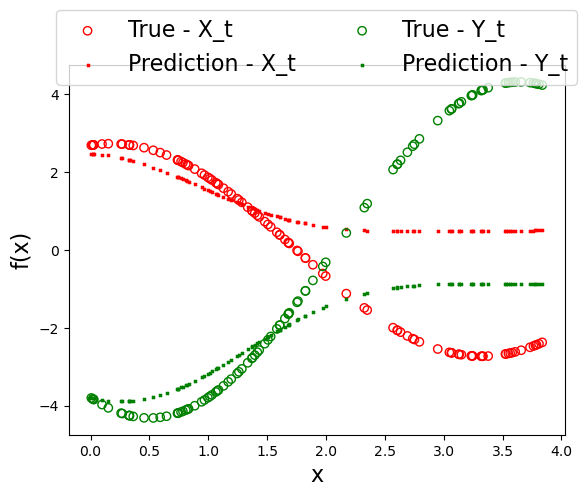

In [25]:
plt.figure()
plt.scatter(t,X_t(t),facecolors='none', edgecolors='r', label='True - X_t')
plt.scatter(t,pred_train_X, color='red',marker="x",s=4,label='Prediction - X_t')
plt.scatter(t,Y_t(t),facecolors='none', edgecolors='g', label='True - Y_t')
plt.scatter(t,pred_train_Y, color='green',marker="x",s=4,label='Prediction - Y_t')
plt.xlabel('x',fontsize=16)
plt.ylabel('f(x)',fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(loc='upper center',bbox_to_anchor=(0.5,1.18),ncol=2,fontsize=16)
# plt.savefig('1_measurement2_train.png')
plt.show()